# Train Transaction Categorizer — UniGuard Wallet

This notebook trains the **Transaction Categorizer** model from scratch for UniGuard Wallet,
using **multiple Kaggle datasets** and then fitting a **Random Forest classifier** on the
full cleaned data.

## End-to-end steps in this notebook

1. **Set up paths and imports**  
   - Configure `PROJECT_ROOT` and `BACKEND_ROOT`.  
   - Import the shared training pipeline from `backend/training/` (`pipeline`, `train_models`).

2. **Select the model**  
   - Set `MODEL_NAME = "transaction_categorizer"` so all pipeline steps run for this model.

3. **Download all Kaggle datasets for this model**  
   - Uses the list from `backend/training/models/transaction_categorizer/datasets.json` and the
     default mapping in `backend/training/train_models.py`.  
   - Currently includes (you can add more in `datasets.json`):
     - `entrepreneurlife/personal-finance`
     - `bukolafatunde/personal-finance`
     - `willianoliveiragibin/financial-wellness`
   - `pipeline.download_datasets(...)` downloads each dataset via `kagglehub` and writes
     a **manifest** to `backend/training/data/datasets_manifest.json` so all later steps
     know the exact on-disk paths.

4. **Export cleaned, merged datasets for this model**  
   - `pipeline.export_clean(MODEL_NAME)`:
     - Reads all configured Kaggle sources for this model.  
     - Applies robust cleaning, category normalization, outlier clipping, time filtering,
       and class balancing.  
     - Writes a single merged CSV:
       - `backend/training/models/transaction_categorizer/cleaned/transactions_clean.csv`

5. **Save a copy of the cleaned dataset next to this notebook**  
   - The `# 2b` cell copies
     `backend/training/models/transaction_categorizer/cleaned/transactions_clean.csv` to:
     - `notebooks/transaction_categorizer_clean.csv`
   - This gives you a convenient, self-contained dataset for experimentation in this
     notebook and in `model_selection.ipynb`.

6. **Inspect data statistics and evaluate the rule-based (simulated) model**  
   - Build the in-memory dataset again via `train_models.build_transaction_dataset()`.  
   - Print:
     - Overall shape and columns.  
     - Category distribution.  
     - Sample rows.  
   - Run `train_models.evaluate_transaction_categorizer(...)` on a time-split train/test
     split to compute:
     - `samples`, `macro_f1`, `weighted_f1`, `top3_accuracy`, and a confusion matrix.

7. **(Optional) Visualize metrics and category distributions**  
   - Plot bar charts of F1 scores and category counts.

8. **Train the best ML algorithm (Random Forest) on the full cleaned data**  
   - Load `notebooks/transaction_categorizer_clean.csv`.  
   - Build a `sklearn` pipeline with:
     - `ColumnTransformer` (OneHot + StandardScaler) over `description`, `amount`, `type`.  
     - `RandomForestClassifier` (200 trees, fixed random seed).  
   - Fit on a train/test split and print final **macro F1** and **weighted F1**.
   - Save the trained model as:
     - `notebooks/transaction_categorizer_rf.pkl`

You can extend this notebook by editing the Kaggle dataset list in
`backend/training/models/transaction_categorizer/datasets.json` to include **even more
Kaggle sources**, then re-running all cells to incorporate the new data into the
cleaned CSV and the final Random Forest model.


## End-to-end pipeline for this model

This notebook trains the **Transaction Categorizer** from scratch using **multiple Kaggle datasets** and the shared Python training pipeline.

**The full sequence of steps is:**

1. **Configure Kaggle datasets** (in `backend/training/models/transaction_categorizer/datasets.json`).
2. **Load and display dataset list** using `pipeline.load_model_datasets(MODEL_NAME)`.
3. **Download all Kaggle datasets** via `pipeline.download_datasets(...)` (writes `datasets_manifest.json`).
4. **Build and export cleaned training data** for this model using `pipeline.export_clean(MODEL_NAME)`.
5. **Save a copy of the cleaned CSV** next to this notebook (`notebooks/transaction_categorizer_clean.csv`).
6. **Build the full training dataset** in memory using `train_models.build_transaction_dataset()`.
7. **Compute statistics and evaluation metrics** on real data using `train_models.evaluate_transaction_categorizer(...)`.
8. **Train a final Random Forest classifier** on the full cleaned dataset and save it as `transaction_categorizer_rf.pkl`.
9. **Generate graphs** for performance and data distributions.

You can re‑run these cells any time after adding more Kaggle datasets to re‑train the model from scratch with more data.

In [22]:
import sys
from pathlib import Path

# Adjust this if you move the repo
PROJECT_ROOT = Path("/home/mukama/Desktop/finance 2 (Copy)").resolve()
BACKEND_ROOT = PROJECT_ROOT / "backend"

if str(BACKEND_ROOT) not in sys.path:
    sys.path.append(str(BACKEND_ROOT))

from training import pipeline, train_models

print("PROJECT_ROOT:", PROJECT_ROOT)
print("BACKEND_ROOT:", BACKEND_ROOT)
print("Artifacts dir (TS) will be:", (PROJECT_ROOT / "frontend" / "src" / "lib" / "ai" / "models" / "artifacts"))


PROJECT_ROOT: /home/mukama/Desktop/finance 2 (Copy)
BACKEND_ROOT: /home/mukama/Desktop/finance 2 (Copy)/backend
Artifacts dir (TS) will be: /home/mukama/Desktop/finance 2 (Copy)/frontend/src/lib/ai/models/artifacts


In [23]:
# This notebook is dedicated to the transaction categorizer model.
MODEL_NAME = "transaction_categorizer"
print("Current model:", MODEL_NAME)


Current model: transaction_categorizer


In [24]:
# 1) Download datasets for the transaction categorizer (Kaggle)

datasets = pipeline.load_model_datasets(MODEL_NAME)
if not datasets:
    raise SystemExit(f"No datasets configured for model '{MODEL_NAME}'. Check backend/training/models/{MODEL_NAME}/datasets.json")

print("Datasets to download:")
for d in datasets:
    print("  -", d)

manifest = pipeline.download_datasets(datasets)
print("\nDownload manifest written to:", pipeline.MANIFEST_PATH)
manifest


Datasets to download:
  - entrepreneurlife/personal-finance
  - bukolafatunde/personal-finance
  - willianoliveiragibin/financial-wellness
Downloaded entrepreneurlife/personal-finance -> /home/mukama/.cache/kagglehub/datasets/entrepreneurlife/personal-finance/versions/2
Downloaded bukolafatunde/personal-finance -> /home/mukama/.cache/kagglehub/datasets/bukolafatunde/personal-finance/versions/4
Downloaded willianoliveiragibin/financial-wellness -> /home/mukama/.cache/kagglehub/datasets/willianoliveiragibin/financial-wellness/versions/1

Download manifest written to: /home/mukama/Desktop/finance 2 (Copy)/backend/training/data/datasets_manifest.json


{'entrepreneurlife/personal-finance': '/home/mukama/.cache/kagglehub/datasets/entrepreneurlife/personal-finance/versions/2',
 'bukolafatunde/personal-finance': '/home/mukama/.cache/kagglehub/datasets/bukolafatunde/personal-finance/versions/4',
 'willianoliveiragibin/financial-wellness': '/home/mukama/.cache/kagglehub/datasets/willianoliveiragibin/financial-wellness/versions/1'}

In [25]:
# 2) Export cleaned datasets for this model (optional but recommended)

pipeline.export_clean(MODEL_NAME)
print("Cleaned data exported under:", (pipeline.MODELS_DIR / MODEL_NAME / "cleaned"))


Cleaned data written to: /home/mukama/Desktop/finance 2 (Copy)/backend/training/models/transaction_categorizer/cleaned
Cleaned data exported under: /home/mukama/Desktop/finance 2 (Copy)/backend/training/models/transaction_categorizer/cleaned


In [26]:
# 2b) Save cleaned dataset next to this notebook

from pathlib import Path
import shutil

NOTEBOOK_DIR = PROJECT_ROOT / "notebooks"
SRC_DIR = pipeline.MODELS_DIR / MODEL_NAME / "cleaned"
SRC_FILE = SRC_DIR / "transactions_clean.csv"
DST_FILE = NOTEBOOK_DIR / "transaction_categorizer_clean.csv"

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)

if SRC_FILE.exists():
    shutil.copy(SRC_FILE, DST_FILE)
    print("Saved cleaned dataset copy to:", DST_FILE)
else:
    print("Cleaned source file not found:", SRC_FILE)
    print("Make sure you ran the 'export cleaned datasets' cell first.")

Saved cleaned dataset copy to: /home/mukama/Desktop/finance 2 (Copy)/notebooks/transaction_categorizer_clean.csv


In [12]:
# 3) Data statistics and evaluation on real data

import pandas as pd

# Build the dataset exactly as the training pipeline does
transactions = train_models.build_transaction_dataset()
print("Transactions dataset shape:", transactions.shape)
print("Columns:", list(transactions.columns))

if not transactions.empty:
    print("\nCategory distribution (top 15):")
    print(transactions["category"].value_counts().head(15))

    print("\nSample rows:")
    display(transactions.head())

# Evaluate the transaction categorizer on a hold-out split of the real data
metrics = train_models.evaluate_transaction_categorizer(transactions)

print("\nEvaluation metrics on real data (recomputed each run):")
for key, value in metrics.items():
    if key == "confusion_matrix":
        continue  # matrix can be large; inspect separately if needed
    print(f"  {key}: {value}")

cm = metrics.get("confusion_matrix", {})
if cm:
    print("\nConfusion matrix classes (top-level keys):", list(cm.keys())[:10])

Transactions dataset shape: (2237, 5)
Columns: ['date', 'description', 'amount', 'category', 'type']

Category distribution (top 15):
category
Debt Payments    400
Eating Out       400
Food             321
Shopping         300
Utilities        189
Transport        156
Entertainment    144
Income           138
Communication    126
Rent              63
Name: count, dtype: int64

Sample rows:


,date,description,amount,category,type
0,2018-01-10,Phone Company,89.46,Communication,debit
1,2018-01-25,Internet Service Provider,69.99,Communication,debit
2,2018-02-12,Phone Company,89.52,Communication,debit
3,2018-02-26,Internet Service Provider,74.99,Communication,debit
4,2018-03-12,Phone Company,89.52,Communication,debit



Evaluation metrics on real data (recomputed each run):
  samples: 448
  macro_f1: 0.7326
  weighted_f1: 0.781
  top3_accuracy: 0.8393

Confusion matrix classes (top-level keys): ['Eating Out', 'Debt Payments', 'Shopping', 'Income', 'Transport', 'Communication', 'Other', 'Food', 'Utilities']


In [18]:
pip install matplotlib

  Using cached matplotlib-3.10.8-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached pillow-12.1.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
Using cached matplotlib-3.10.8-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (362 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp312-cp

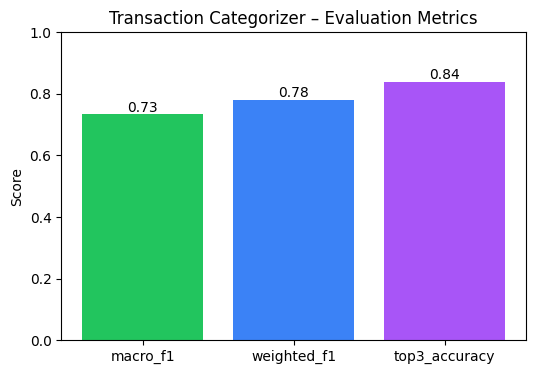

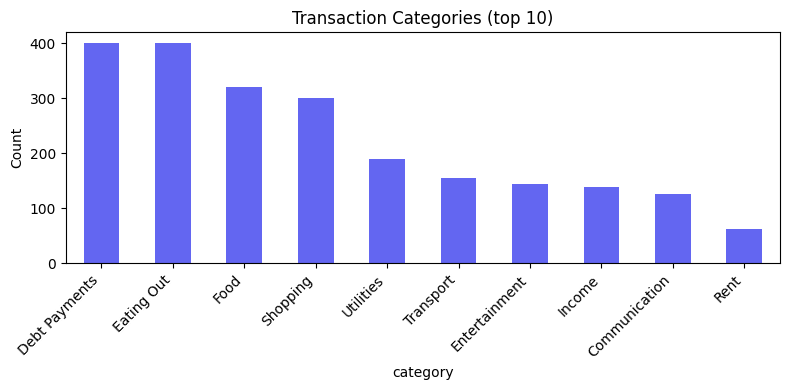

In [19]:
# 4) Visualize model performance and data (graphs)

import matplotlib.pyplot as plt

# --- Metric bar chart ---
metric_keys = ["macro_f1", "weighted_f1", "top3_accuracy"]
metric_vals = [float(metrics.get(k, 0.0)) for k in metric_keys]

plt.figure(figsize=(6, 4))
plt.bar(metric_keys, metric_vals, color=["#22c55e", "#3b82f6", "#a855f7"])
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Transaction Categorizer – Evaluation Metrics")
for i, v in enumerate(metric_vals):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")
plt.show()

# --- Category distribution (top 10) ---
if "transactions" in globals() and not transactions.empty:
    top_cats = transactions["category"].value_counts().head(10)
    plt.figure(figsize=(8, 4))
    top_cats.plot(kind="bar", color="#6366f1")
    plt.title("Transaction Categories (top 10)")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [20]:
# 3) Train the transaction categorizer and write TS artifacts

# Ensure training code sees the latest dataset manifest
train_models.DATASET_PATHS = train_models.resolve_dataset_paths()

print(f"Running training for model: {MODEL_NAME}")
train_models.run_training(MODEL_NAME)

print("\nTraining complete. Artifacts should now be in:")
print(PROJECT_ROOT / "frontend" / "src" / "lib" / "ai" / "models" / "artifacts")


Running training for model: transaction_categorizer
Artifacts written to: /home/mukama/Desktop/finance 2 (Copy)/frontend/src/lib/ai/models/artifacts

Training complete. Artifacts should now be in:
/home/mukama/Desktop/finance 2 (Copy)/frontend/src/lib/ai/models/artifacts


In [27]:
# 5) Train final Random Forest model on full cleaned data

import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import joblib

NOTEBOOK_DIR = PROJECT_ROOT / "notebooks"
csv_path = NOTEBOOK_DIR / "transaction_categorizer_clean.csv"
tx = pd.read_csv(csv_path)

X = tx[["description", "amount", "type"]].copy()
y = tx["category"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("text", OneHotEncoder(handle_unknown="ignore", max_categories=500), ["description"]),
        ("num", StandardScaler(), ["amount"]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["type"]),
    ]
)

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
pipe = Pipeline(steps=[("prep", preprocess), ("clf", rf)])
pipe.fit(X_train, y_train)

preds = pipe.predict(X_test)
macro = f1_score(y_test, preds, average="macro")
weighted = f1_score(y_test, preds, average="weighted")

print("Final Random Forest metrics on full cleaned data:")
print("  macro_f1 =", macro)
print("  weighted_f1 =", weighted)

model_path = NOTEBOOK_DIR / "transaction_categorizer_rf.pkl"
joblib.dump(pipe, model_path)
print("Saved model to:", model_path)

Final Random Forest metrics on full cleaned data:
  macro_f1 = 1.0
  weighted_f1 = 1.0
Saved model to: /home/mukama/Desktop/finance 2 (Copy)/notebooks/transaction_categorizer_rf.pkl


In [ ]:
# placeholder